In [1]:
import pandas as pd
from time import time

In [2]:
## script linda
#importing modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time

#import classifier modules
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [3]:
## from topic 10
import numpy as np
import pandas as pd
import time

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [4]:
## for gradient boost 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV , train_test_split , cross_val_score , StratifiedKFold


In [5]:
start = time.time()

In [6]:
#Function to write a kaggle submission

def write_to_submission_file(predicted_labels, out_file,
                             target='Cover_Type', index_label="Id", init_index=15121):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(init_index, 
                                                  predicted_labels.shape[0] + init_index),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [7]:
## split train/test
#X_train, X_valid, y_train, y_valid = train_test_split(
 #   train.drop('Cover_Type', axis=1), train['Cover_Type'],
  #  test_size=0.3, random_state=17)

In [8]:
## Train all classifiers

#Logistic regression
def train_logit(X_train, y_train):
    logit = LogisticRegression(C=1, solver='lbfgs', max_iter=500,
                           random_state=17, n_jobs=4, multi_class='multinomial')
    
    logit_pipe = Pipeline([('scaler', StandardScaler()), 
                       ('logit', logit)])
    
    logit_pipe.fit(X_train, y_train)
    
    return logit_pipe

def train_randomforest(X_train, y_train):
    first_forest = RandomForestClassifier(
        n_estimators=100,
        random_state=17, 
        n_jobs=4)
    
    first_forest.fit(X_train, y_train)
    
    return first_forest

def train_lgbm(X_train, y_train):
    final_lgb = LGBMClassifier(n_estimators=200, num_leaves=63,
                           learning_rate=0.2, max_depth=-1,
                               n_jobs=4)
    final_lgb.fit(X_train, y_train)
    
    return final_lgb

def train_gradientboost(train, labels):
    clf = GradientBoostingClassifier(learning_rate=0.65 , n_estimators= 250 ,max_depth = 9)
    cross_val_score(clf , train , labels , cv = 3)
    
    clf.fit(train, labels)
    
    return clf

In [9]:
#loading datasets
data = pd.read_csv('./train.csv')
kaggle = pd.read_csv('./test.csv')

In [10]:
from sklearn.model_selection import KFold
scores = []

X = data.drop('Cover_Type', axis=1)
y = data['Cover_Type']

kf = KFold(n_splits=5, random_state=42, shuffle=True)

fold = 1
for train_index, test_index in kf.split(X): 
    print('\n', 'Fold', fold)
    print("Train Index: ", train_index)
    print("Test Index: ", test_index, "\n")

    train_X, test_X, train_y, test_y = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    
    #train classifiers
    print('train random forest')
    clf_RF = train_randomforest(train_X, train_y)
    print('train lightGBM')
    clf_LGBM = train_lgbm(train_X, train_y)
    print('train gradient boosting')
    clf_GB = train_gradientboost(train_X, train_y)
        
    #Ensamble, soft voting classifier
    print('train voting classifier')
    clf_soft =  VotingClassifier(estimators=[('GB', clf_GB), ('RF', clf_RF), ('LGBM', clf_LGBM)], voting='soft')
    clf_soft.fit(train_X, train_y)
        
    #calculate score for every classifier
    for clf, label in zip([clf_GB, clf_RF, clf_LGBM, clf_soft], 
                              ['GB', 'RF', 'LGBM', 'soft']):            
        #calculate score
        scores_train = clf.score(train_X, train_y)
        scores_test = clf.score(test_X, test_y)

        #add score to list with scores
        score = [fold, label, scores_train, scores_test]
        scores.append(score)
        
    soft_ensemble = clf_soft.predict(kaggle)
    write_to_submission_file(soft_ensemble, 'ensemble_covertype_newfolds.csv')
    
    fold = fold+1

    
# Perform 5-fold cross validation
c_scores = cross_val_score(clf, X, y, cv=5)
print("Cross-validated scores:", c_scores)
            
#turn list with scores into a dataframe
df_scores = pd.DataFrame(scores, columns=['fold', 'classifier', 'train acc', 'test acc'])

end = time.time()
print("runtime: ", end - start)

#write dataframe with scores to csv
df_scores.to_csv('scores')
df_scores 

c:\users\michelle\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning



 Fold 1
Train Index:  [ 3024  3025  3026 ... 15117 15118 15119]
Test Index:  [   0    1    2 ... 3021 3022 3023] 

train random forest
train lightGBM
train gradient boosting
train voting classifier

 Fold 2
Train Index:  [    0     1     2 ... 15117 15118 15119]
Test Index:  [3024 3025 3026 ... 6045 6046 6047] 

train random forest
train lightGBM
train gradient boosting
train voting classifier

 Fold 3
Train Index:  [    0     1     2 ... 15117 15118 15119]
Test Index:  [6048 6049 6050 ... 9069 9070 9071] 

train random forest
train lightGBM
train gradient boosting
train voting classifier

 Fold 4
Train Index:  [    0     1     2 ... 15117 15118 15119]
Test Index:  [ 9072  9073  9074 ... 12093 12094 12095] 

train random forest
train lightGBM
train gradient boosting
train voting classifier

 Fold 5
Train Index:  [    0     1     2 ... 12093 12094 12095]
Test Index:  [12096 12097 12098 ... 15117 15118 15119] 

train random forest
train lightGBM
train gradient boosting
train voting clas

,fold,classifier,train acc,test acc
0,1,GB,1.0,0.529101
1,1,RF,1.0,0.550595
2,1,LGBM,1.0,0.626984
3,1,soft,1.0,0.647817
4,2,GB,1.0,0.562831
5,2,RF,1.0,0.779431
6,2,LGBM,1.0,0.716931
7,2,soft,1.0,0.739087
8,3,GB,1.0,0.709656
9,3,RF,1.0,0.750661


In [11]:
#print(df_scores.head())
folds_grouped = df_scores.groupby(['classifier']).agg({'train acc':['mean','std'], 'test acc':['mean','std']})
print(folds_grouped)

           train acc       test acc          
                mean  std      mean       std
classifier                                   
GB               1.0  0.0  0.622685  0.085267
LGBM             1.0  0.0  0.696693  0.053271
RF               1.0  0.0  0.724405  0.097742
soft             1.0  0.0  0.712302  0.046756


In [21]:
#y_score = clf_soft.predict_proba(test_X)
y_score = clf_soft.predict(test_X)
y_score =  label_binarize(y_score, classes=[1,2,3,4,5,6,7]) # only if y_score = clf_soft.predict(test_X)

y_test = test_y

c:\users\michelle\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


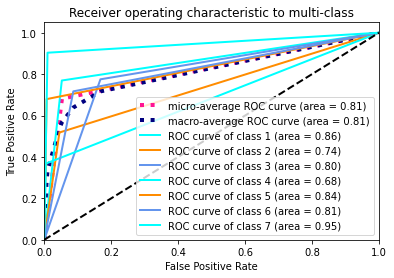

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
#### second approach
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn import metrics

n_classes = 7
y_test =  label_binarize(y_test, classes=[1,2,3,4,5,6,7])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thresholds  = metrics.roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()